In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import models, layers, callbacks, optimizers, regularizers
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
def Split(x, y, seed=0):
    a = int(0.8 * x.shape[0])
    b = int(0.9 * x.shape[0])
    index = np.arange(a)
    np.random.seed(seed)
    np.random.shuffle(index)
    return x[:a][index], y[:a][index], x[a:b], y[a:b], x[b:], y[b:]

In [3]:
class StandardScaler:
    def __init__(self, data):
        self.mean = np.mean(data)
        self.std = np.std(data)

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return data * self.std + self.mean

In [4]:
def Net(shape1, shape2):
    inputs1 = layers.Input(shape=shape1)
    a = layers.TimeDistributed(layers.Conv1D(32, kernel_size=4, padding='same'))(inputs1)
    a = layers.LeakyReLU(0.2)(a)
    a = layers.TimeDistributed(layers.MaxPool1D())(a)
    a = layers.TimeDistributed(layers.Conv1D(32, kernel_size=2, padding='same'))(a)
    a = layers.LeakyReLU(0.2)(a)
    a = layers.TimeDistributed(layers.MaxPool1D())(a)
    a = layers.TimeDistributed(layers.Flatten())(a)
    a = layers.LSTM(64, return_sequences=True)(a)
    a = layers.LSTM(64)(a)
    inputs2 = layers.Input(shape=shape2)
    b = layers.Concatenate()([a, inputs2])
    b = layers.Dense(1)(b)
    return models.Model(inputs=[inputs1, inputs2], outputs=b)

In [5]:
df = pd.read_csv('bdi.csv', parse_dates=['date'], index_col=['date'])
df

,bdi
date,
2000-01-01,1319.0
2000-01-02,NaN
2000-01-03,NaN
2000-01-04,1320.0
2000-01-05,1329.0
...,...
2020-10-05,2071.0
2020-10-06,2097.0
2020-10-07,2044.0


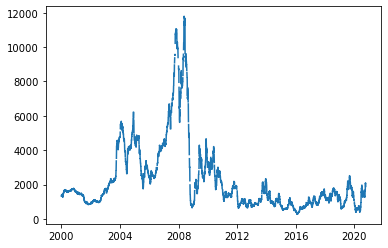

In [6]:
plt.plot(df)

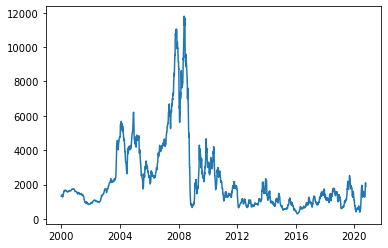

In [7]:
df.fillna(method='ffill', inplace=True)
plt.plot(df)

In [8]:
train = pd.read_csv('train.csv').values
val = pd.read_csv('val.csv').values
test = pd.read_csv('test.csv').values

In [9]:
data = df.values

In [10]:
y = np.array([data[i] for i in range(90, data.shape[0])]).reshape(-1,1)
x = np.array([data[i-30:i] for i in range(30, data.shape[0])]).reshape(-1,30,1)
x = np.array([x[i-61:i] for i in range(61, x.shape[0]+1)])

In [11]:
x_train, y_train, x_val, y_val, x_test, y_test = Split(x, y, seed=42)

In [12]:
scaler = StandardScaler(y_train)
x_train = scaler.transform(x_train)
y_train = scaler.transform(y_train)
x_val = scaler.transform(x_val)
y_val = scaler.transform(y_val)
x_test = scaler.transform(x_test)

In [13]:
model = Net([x.shape[1], x.shape[2], x.shape[3]], [train.shape[1]])
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 61, 30, 1)]  0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 61, 30, 32)   160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 61, 30, 32)   0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 61, 15, 32)   0           leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [14]:
filepath = 'checkpoint_concat.h5'
checkpoint = callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)
h0 = model.fit([x_train, train],y_train, validation_data=([x_val, val], y_val),
               batch_size=128, epochs=100, callbacks=[checkpoint], shuffle=True)
model = models.load_model(filepath)
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9))
h1 = model.fit([x_train, train], y_train, validation_data=([x_val, val], y_val), 
               batch_size=128, epochs=100, callbacks=[checkpoint], shuffle=True)
model = models.load_model(filepath)

Epoch 1/100
47/47 [==============================] - 5s 113ms/step - loss: 0.1181 - val_loss: 0.0378
Epoch 2/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0351 - val_loss: 0.0174
Epoch 3/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0232 - val_loss: 0.0104
Epoch 4/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0145 - val_loss: 0.0064
Epoch 5/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0102 - val_loss: 0.0049
Epoch 6/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0078 - val_loss: 0.0027
Epoch 7/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 8/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 9/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 10/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0028 - val_loss: 0.001

Epoch 78/100
47/47 [==============================] - 1s 20ms/step - loss: 7.4841e-04 - val_loss: 1.3401e-04
Epoch 79/100
47/47 [==============================] - 1s 21ms/step - loss: 3.9133e-04 - val_loss: 1.2588e-04
Epoch 80/100
47/47 [==============================] - 1s 20ms/step - loss: 6.7455e-04 - val_loss: 2.1682e-04
Epoch 81/100
47/47 [==============================] - 1s 20ms/step - loss: 7.4443e-04 - val_loss: 2.3794e-04
Epoch 82/100
47/47 [==============================] - 1s 20ms/step - loss: 5.6704e-04 - val_loss: 2.3409e-04
Epoch 83/100
47/47 [==============================] - 1s 20ms/step - loss: 4.0284e-04 - val_loss: 1.6394e-04
Epoch 84/100
47/47 [==============================] - 1s 20ms/step - loss: 3.7453e-04 - val_loss: 2.1374e-04
Epoch 85/100
47/47 [==============================] - 1s 20ms/step - loss: 4.3695e-04 - val_loss: 2.5354e-04
Epoch 86/100
47/47 [==============================] - 1s 20ms/step - loss: 3.3620e-04 - val_loss: 2.4739e-04
Epoch 87/100
47/47 

47/47 [==============================] - 1s 20ms/step - loss: 2.4942e-04 - val_loss: 9.9290e-05
Epoch 54/100
47/47 [==============================] - 1s 21ms/step - loss: 2.4968e-04 - val_loss: 9.8584e-05
Epoch 55/100
47/47 [==============================] - 1s 20ms/step - loss: 2.4915e-04 - val_loss: 9.9405e-05
Epoch 56/100
47/47 [==============================] - 1s 20ms/step - loss: 2.4949e-04 - val_loss: 1.0121e-04
Epoch 57/100
47/47 [==============================] - 1s 20ms/step - loss: 2.4926e-04 - val_loss: 9.9683e-05
Epoch 58/100
47/47 [==============================] - 1s 20ms/step - loss: 2.4953e-04 - val_loss: 9.8850e-05
Epoch 59/100
47/47 [==============================] - 1s 20ms/step - loss: 2.4964e-04 - val_loss: 9.9860e-05
Epoch 60/100
47/47 [==============================] - 1s 20ms/step - loss: 2.4922e-04 - val_loss: 9.8767e-05
Epoch 61/100
47/47 [==============================] - 1s 20ms/step - loss: 2.4895e-04 - val_loss: 1.0082e-04
Epoch 62/100
47/47 [============

In [15]:
predict = model.predict([x_test, test])
predict = scaler.inverse_transform(predict)

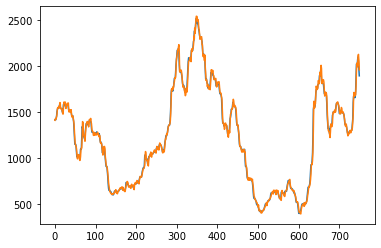

In [16]:
plt.plot(y_test)
plt.plot(predict)

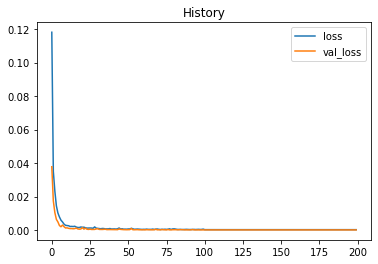

In [17]:
plt.plot(h0.history['loss'] + h1.history['loss'], label='loss')
plt.plot(h0.history['val_loss'] + h1.history['val_loss'], label='val_loss')
plt.title(f'History')
plt.legend()
plt.show()

In [18]:
metrics.mean_absolute_error(y_test, predict)

21.51896516927083